In [39]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

In [40]:
# import raw data

df_raw = pd.read_csv('C:\\Users\\Sonja\\Udacity\\machine-learning-master\\machine-learning-master\\projects\\capstone\\loans\\loan.csv',\
                     low_memory=False)

In [41]:
# group loan status duplicates

def group_status(status):
    if status == 'Does not meet the credit policy. Status:Charged Off':
        return 'Charged Off'
    elif status == 'Does not meet the credit policy. Status:Fully Paid':
        return 'Fully Paid'
    elif status in ['Late (16-30 days)', 'Late (31-120 days)']:
        return 'Late'
    else:
        return status

df_raw['loan_status_new'] = df_raw['loan_status'].apply(group_status)

In [42]:
#pd.set_option('display.max_columns', len(df_raw.columns))
df_raw.head(1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,loan_status_new
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid


The raw data contain a mix of numeric data and objects and will require some preprocessing. NAN values have to be addressed. Certain variables may also require scaling or transformation into dummy variables.

In [43]:
#create column in original dataset to distinguish between good or bad loans
#this will be the target variable for subsequent predictive models

gl = []

for row in df_raw['loan_status_new']:
    if row == 'Current':
        gl.append(1)
    elif row == 'Issued':
        gl.append(1)
    elif row == 'Fully Paid':
        gl.append(1)
    else: 
        gl.append(0)

df_raw['good_bad_loans']=gl
  

## Exploratory data analysis

In [16]:
loan_status = df_raw.groupby('loan_status_new').agg([np.count_nonzero])
loan_status = loan_status['id'].reset_index()
loan_status['percentage'] = loan_status['count_nonzero']/loan_status['count_nonzero'].sum()
loan_status

,loan_status_new,count_nonzero,percentage
0,Charged Off,46009,0.051848
1,Current,601779,0.678153
2,Default,1219,0.001374
3,Fully Paid,209711,0.236326
4,In Grace Period,6253,0.007047
5,Issued,8460,0.009534
6,Late,13948,0.015718


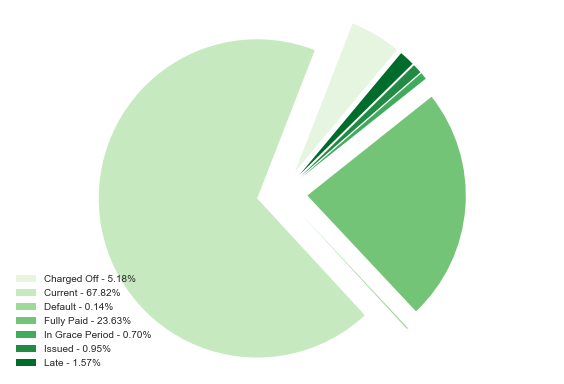

In [17]:
colors = sns.color_palette("Greens", n_colors=7, desat=1)

labels = ['{0} - {1:1.2f}%'.format(i,j) for i,j in zip(loan_status['loan_status_new'], (loan_status['percentage']*100))]
explode=(0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04)
plt.pie(loan_status['percentage'], colors=colors, explode=explode, startangle=50, radius=0.25)
plt.legend(labels, loc='lower left', fontsize=10)
plt.axis('equal')
plt.tight_layout()
plt.show()

The dataset is highly unbalanced, with good loans (=Current, Fully Paid and Issued) accounting for 92.4% of all loans.

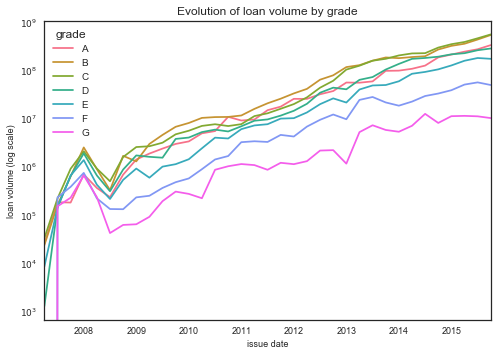

In [18]:
#Evolution of loan volume by grade

#first we need to convert the data in 'issue_d' from object into datetime format
df_raw['issue_d'] = pd.to_datetime(df_raw.issue_d)

colors = sns.color_palette("husl", n_colors=7, desat=1)
table = pd.pivot_table(df_raw, values='loan_amnt', index='issue_d', columns=['grade'], aggfunc=np.sum)
table = table.resample('Q').sum().fillna(0)
sns.set_style("white")
ax = table.plot(color=colors, logy=True, title='Evolution of loan volume by grade', fontsize=9)
ax.set_xlabel('issue date', fontsize=9)
ax.set_ylabel('loan volume (log scale)', fontsize=9)

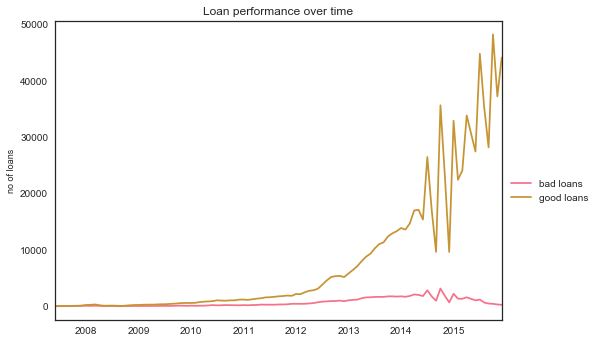

In [19]:
#How has loan performance varied over time?

table2 = pd.pivot_table(data=df_raw,index='issue_d',columns='good_bad_loans',values='id',\
                        aggfunc='count').fillna(0)
table2.columns = ['bad loans', 'good loans']
ax2 = table2.plot(legend=False, color=colors, title='Loan performance over time')
ax2.set_ylabel('no of loans', fontsize=9)
ax2.set_xlabel('', fontsize=9)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))

In [20]:
#What is the relationship between interest rate and loan performance?

table3 = pd.pivot_table(data=df_raw,index='issue_d',columns='good_bad_loans',values='int_rate',\
                        aggfunc='mean').fillna(df_raw['int_rate'].mean())
table3 = table3.resample('12M').mean()
table3.columns = ['bad loans', 'good loans']
table3.head(1)

,bad loans,good loans
issue_d,,
2007-06-30,10.17,9.76381


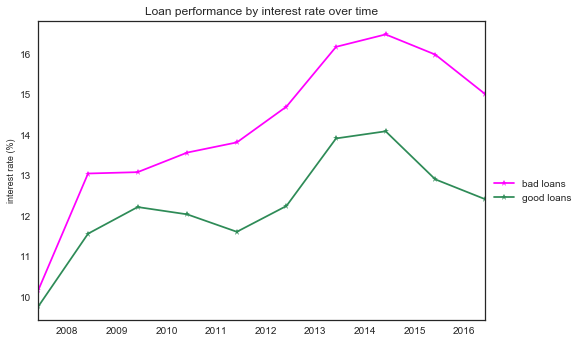

In [21]:
colors = ('magenta', 'seagreen')
#colors = sns.color_palette("husl", n_colors=7, desat=1) # husl

ax3 = table3.plot(legend=False, color=colors, marker='*',
                  title='Loan performance by interest rate over time')
ax3.set_xlabel('', fontsize=9)
ax3.set_ylabel('interest rate (%)', fontsize=9)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))

In [148]:
#What is the relationship between loan grade and loan performance?

table4 = pd.pivot_table(df_raw, values='id', index='grade', columns='good_bad_loans',\
                        aggfunc='count')
table4.columns = ['bad loans', 'good loans']
table4 =table4.transpose()/table4.sum(axis=1)*100
table4

grade,A,B,C,D,E,F,G
bad loans,2.471627,5.286503,7.749939,11.365037,13.782618,19.018485,23.118965
good loans,97.528373,94.713497,92.250061,88.634963,86.217382,80.981515,76.881035


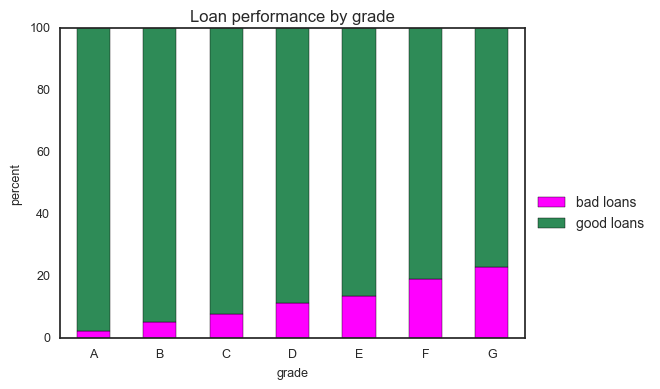

In [149]:
colors = ('magenta','seagreen')
ax4= table4.transpose().plot(legend=False, kind='bar',stacked=True, ylim=(0,100),\
                             color=colors, fontsize=9, title='Loan performance by grade')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
ax4.set_xticklabels('ABCDEFG', rotation=0)
ax4.set_ylabel('percent', fontsize=9)
ax4.set_xlabel('grade', fontsize=9)

(-0.5, 399.5, 199.5, -0.5)

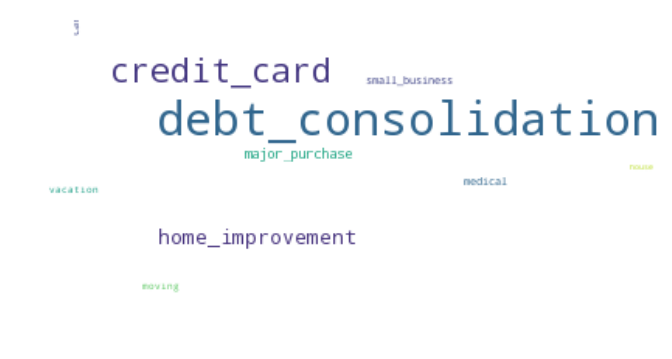

In [150]:
#What are the main loan purposes? - using purpose column

from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(8,6))
words = df_raw['purpose'].to_json()
wc = WordCloud(ranks_only=True,background_color='white',max_words=10).generate(words)             
plt.imshow(wc)
plt.axis("off")



In [151]:
#How is the loan purpose related to loan performance?

table5 = pd.pivot_table(df_raw, values='id', index='purpose', \
                        columns='good_bad_loans', aggfunc='count').fillna(0)
table5.columns = ['bad loans', 'good loans']
table5['Sum'] = table5['bad loans'] + table5['good loans']
table5['percent_good_loans'] = table5['good loans']/table5['Sum']*100
table5['percent_bad_loans'] = table5['bad loans']/table5['Sum']*100

table5.drop(table5.columns[[0, 1, 2]], axis=1, inplace=True)

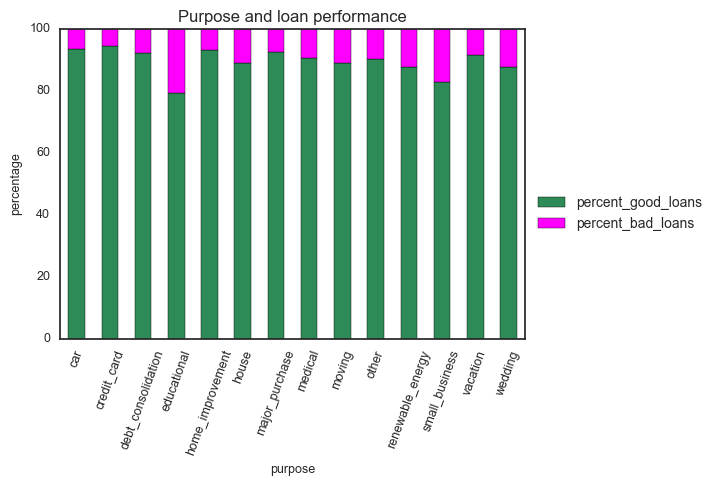

In [152]:
colors = ('seagreen','magenta')
ax5= table5.plot(legend=False, kind='bar',stacked=True, ylim=(0,100), color=colors, fontsize=9,\
                title='Purpose and loan performance')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
ax5.set_xticklabels(table5.index, rotation=70)
ax5.set_xlabel('purpose', fontsize=9)
ax5.set_ylabel('percentage', fontsize=9)

(-0.5, 399.5, 199.5, -0.5)

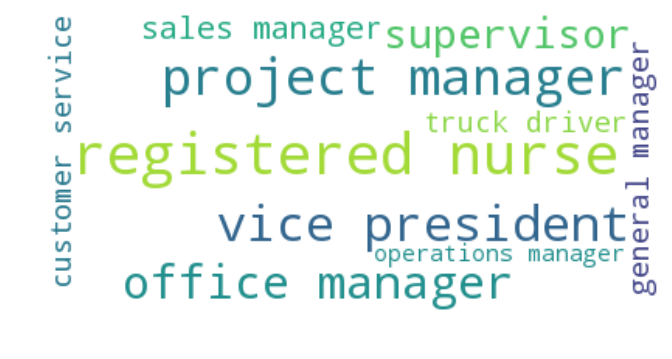

In [153]:
#What are the most frequent job titles?

# adding specific stopwords
stopwords = set(STOPWORDS)
stopwords.add("Inc")
stopwords.add("null")

plt.figure(figsize=(8,6))
words = df_raw['emp_title'].str.lower().to_json()
wc = WordCloud(ranks_only=True,stopwords=stopwords, background_color='white',max_words=10).generate(words)             
plt.imshow(wc)
plt.axis("off")

In [154]:
# frequency of job titles
from nltk import FreqDist

fdist = FreqDist(df_raw['emp_title'].str.lower())

fdist = fdist.most_common(10)
fdist

[(nan, 51457),
 ('teacher', 16619),
 ('manager', 14963),
 ('owner', 8586),
 ('registered nurse', 7721),
 ('supervisor', 6937),
 ('driver', 6215),
 ('sales', 6208),
 ('rn', 6017),
 ('office manager', 4687)]

In [155]:
#How is occupation related to loan performance?

df_raw['emp_title'] = df_raw['emp_title'].astype(str).str.lower()

table6 = pd.pivot_table(df_raw, values='id', index='emp_title', columns='good_bad_loans', aggfunc='sum').fillna(0)
table6.columns = ['bad loans', 'good loans']
table6 = table6.sort_values(by='bad loans', axis=0, ascending=False)
table6 = table6.iloc[:30]

#show bad loans as percentage of total loans for most frequent job titles

table6['sum'] = table6['bad loans'] + table6['good loans']
table6['percent_good_loans'] = table6['good loans']/table6['sum']*100
table6['percent_bad_loans'] = table6['bad loans']/table6['sum']*100

table6.drop(table6.columns[[0, 1, 2]], axis=1, inplace=True)

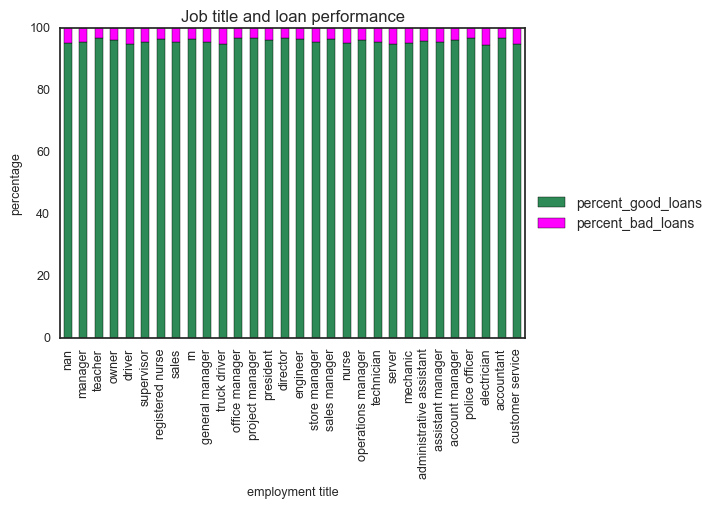

In [156]:
ax6= table6.plot(legend=False, kind='bar',stacked=True, ylim=(0,100), color=colors, fontsize=9,\
                title='Job title and loan performance')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
ax6.set_xticklabels(table6.index, rotation=90)
ax6.set_xlabel('employment title', fontsize=9)
ax6.set_ylabel('percentage', fontsize=9)

In [157]:
#How is home ownership related to loan performance?

table9 = pd.pivot_table(df_raw, values='id', index='home_ownership', columns=['good_bad_loans'], aggfunc=np.sum).fillna(0)
table9.columns=[['bad loans', 'good loans']]
table9['Sum']=table9['bad loans']+table9['good loans']
table9['percent_good_loans']=table9['good loans']/table9['Sum']*100
table9['percent_bad_loans']=table9['bad loans']/table9['Sum']*100
table10 = table9[['percent_good_loans', 'percent_bad_loans']]

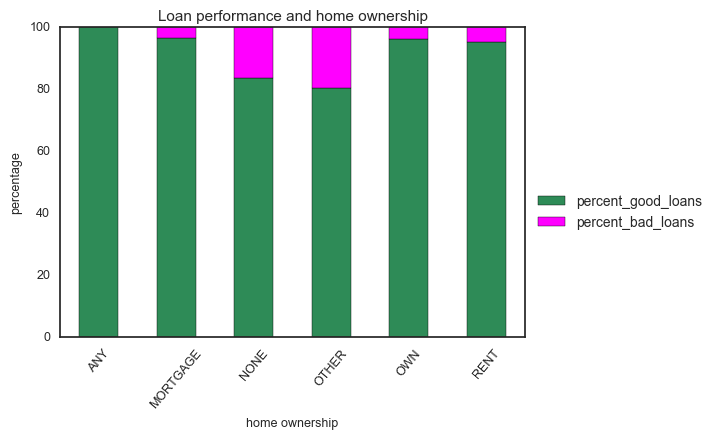

In [158]:
ax10 = table10.plot(kind='bar', legend=False, color=colors, stacked=True, fontsize=9)
ax10.set_xticklabels(table10.index, fontsize=9, rotation=50)
ax10.set_xlabel('home ownership', fontsize=9)
ax10.set_ylabel('percentage', fontsize=9)
ax10.set_title('Loan performance and home ownership', fontsize=11)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))

In [173]:
#How is loan performance related to applicant state?

table11 = pd.pivot_table(df_raw, values='id', index='addr_state', columns=['good_bad_loans'], aggfunc='count').fillna(0)
table11.columns=[['bad loans', 'good loans']]
table11['Sum']=table11['bad loans']+table11['good loans']
table11['%good_loans']=table11['good loans']/table11['Sum']*100
table11['%bad_loans']=table11['bad loans']/table11['Sum']*100
table11.index = table11.index.astype(str)
table11['above mean'] = table11['%bad_loans'] - table11['%bad_loans'].mean()  
print(table11)

            bad loans  good loans     Sum  %good_loans  %bad_loans  above mean
addr_state                                                                    
AK                151        2054    2205    93.151927    6.848073   -0.364510
AL                993       10207   11200    91.133929    8.866071    1.653489
AR                507        6133    6640    92.364458    7.635542    0.422960
AZ               1581       18831   20412    92.254556    7.745444    0.532861
CA              10518      118999  129517    91.879058    8.120942    0.908359
CO               1187       17620   18807    93.688520    6.311480   -0.901103
CT                922       12609   13531    93.186017    6.813983   -0.398600
DC                118        2314    2432    95.148026    4.851974   -2.360609
DE                189        2322    2511    92.473118    7.526882    0.314299
FL               5148       55787   60935    91.551653    8.448347    1.235764
GA               2061       27024   29085    92.9138

In [61]:
#Plot bad loans on map

import plotly.plotly as py
py.sign_in('Son17', 'MSEN5RpZycgv0ai5OvWm')

data = [ dict(
        type='choropleth',
        colorscale = 'Greens',
        autocolorscale = False,
        locations = table11.index,
        z = table11['%bad_loans'].astype(float).round(2),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(title = "Portion of bad loans (%)"))]

layout = dict(
        title = 'Bad loans by state (%)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),)
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )

NameError: name 'table11' is not defined

Yikes! Bad loans are concentrated in Iowa with 21.43%. However, only 14 loans have been made to applicants from Iowa, a tiny proportion of the entire dataset. 

In [ ]:
#Plot bad loans on map


import plotly.plotly as py
py.sign_in('Son17', 'MSEN5RpZycgv0ai5OvWm')

data = [ dict(
        type='choropleth',
        colorscale = 'Reds',
        autocolorscale = False,
        locations = table11.index,
        z = table11['Sum'].astype(float).round(2),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(title = "No of loans"))]

layout = dict(
        title = 'No of loans by state (%)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),)
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )

The largest no of loans has been issued to applicants in California. However, the percentage of bad loans is only 0.91% over the mean percentage of bad loans per state (7.21%).

## Data pre-processing

In [6]:
# Check data types to find out what columns have to be transformed

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 76 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835922 non-null object
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [44]:
# Deal with NAN values
df_raw = df_raw.fillna(0)

In [45]:
#Drop columns that have no predictive power on loan performance

df_raw_dropped = df_raw.drop(['id','member_id', 'url', 'desc', 'title',\
                              'collection_recovery_fee',\
                              'collections_12_mths_ex_med', 'funded_amnt', 'funded_amnt_inv',\
                              'verification_status','verification_status_joint', 'emp_title',\
                              'total_rec_late_fee', 'initial_list_status', 'recoveries',\
                              'acc_now_delinq', 'policy_code', 'pymnt_plan',\
                              'loan_status', 'loan_status_new'],axis=1)

In [46]:
#Encode columns containing object data types

from sklearn import preprocessing 

le = preprocessing.LabelEncoder()
  
df_raw_dropped['term'] = le.fit_transform(df_raw_dropped['term'])
df_raw_dropped['grade'] = le.fit_transform(df_raw_dropped['grade'])
df_raw_dropped['sub_grade'] = le.fit_transform(df_raw_dropped['sub_grade'])
df_raw_dropped['home_ownership'] = le.fit_transform(df_raw_dropped['home_ownership'])
df_raw_dropped['purpose'] = le.fit_transform(df_raw_dropped['purpose'])
df_raw_dropped['zip_code'] = le.fit_transform(df_raw_dropped['zip_code'])
df_raw_dropped['addr_state'] = le.fit_transform(df_raw_dropped['addr_state'])
df_raw_dropped['application_type'] = le.fit_transform(df_raw_dropped['application_type'])
df_raw_dropped['emp_length'] = le.fit_transform(df_raw_dropped['emp_length'])

df_raw_dropped.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,issue_d,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,good_bad_loans
0,5000.0,0,10.65,162.87,1,6,1,5,24000.0,Dec-2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2500.0,1,15.27,59.83,2,13,10,5,30000.0,Dec-2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2400.0,0,15.96,84.33,2,14,1,5,12252.0,Dec-2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,10000.0,0,13.49,339.31,2,10,1,5,49200.0,Dec-2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,3000.0,1,12.69,67.79,1,9,0,5,80000.0,Dec-2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [47]:
# Convert date objects into ordinal numbers

df_raw['issue_d'] = pd.to_datetime(df_raw.issue_d)
df_raw['issue_d'] = df_raw['issue_d'].apply(datetime.date.toordinal)

In [48]:
df_raw['earliest_cr_line'] = pd.to_datetime(df_raw.earliest_cr_line)
df_raw['earliest_cr_line'] = df_raw['earliest_cr_line'].apply(datetime.date.toordinal)

In [49]:
df_raw['last_pymnt_d'] = pd.to_datetime(df_raw.last_pymnt_d)
df_raw['last_pymnt_d'] = df_raw['last_pymnt_d'].apply(datetime.date.toordinal)

In [50]:
df_raw['next_pymnt_d'] = pd.to_datetime(df_raw.next_pymnt_d)
df_raw['next_pymnt_d'] = df_raw['next_pymnt_d'].apply(datetime.date.toordinal)

In [51]:
df_raw['last_credit_pull_d'] = pd.to_datetime(df_raw.last_credit_pull_d)
df_raw['last_credit_pull_d'] = df_raw['last_credit_pull_d'].apply(datetime.date.toordinal)

In [52]:
# Concatenate converted date columns and df_encoded

df_encoded = df_raw_dropped.drop(['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d',\
                      'last_credit_pull_d'], axis=1)

df = pd.concat([df_raw[['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d',\
                      'last_credit_pull_d']], df_encoded], axis=1)

   
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 56 columns):
issue_d                        887379 non-null int64
earliest_cr_line               887379 non-null int64
last_pymnt_d                   887379 non-null int64
next_pymnt_d                   887379 non-null int64
last_credit_pull_d             887379 non-null int64
loan_amnt                      887379 non-null float64
term                           887379 non-null int64
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null int64
sub_grade                      887379 non-null int64
emp_length                     887379 non-null int64
home_ownership                 887379 non-null int64
annual_inc                     887379 non-null float64
purpose                        887379 non-null int64
zip_code                       887379 non-null int64
addr_state                     88

## Split dataset into training and testing sets

In [53]:
# Define X and y

y = df['good_bad_loans']
y.columns = ['good_bad_loans']
X = df.drop(['good_bad_loans'], axis=1)

In [54]:
# Train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Build benchmark model

In [21]:
# Build benchmark model (logistic regression)

from sklearn import linear_model

regr = linear_model.LogisticRegression(random_state=42)
regr.fit(X_train, y_train)

y_pred_regr = regr.predict(X_test)

In [22]:
# Assess benchmark model performance using area under the curve (AUC)

from sklearn.metrics import roc_auc_score

AUC = roc_auc_score(y_test, y_pred_regr)
print("The AUC score for a simple Logistic Regression model is {:.4f}.".format(AUC))

The AUC score for a simple Logistic Regression model is 0.8206.


## Build basic models

In [24]:
# Build model using Gaussian Naive Bayes classifier

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)

# Assess model performance

AUC = roc_auc_score(y_test, y_pred_gnb)
print("The AUC score for a Gaussian Naive Bayes model is {:.4f}.".format(AUC))

The AUC score for a Gaussian Naive Bayes model is 0.6095.


In [25]:
# Build model using RandomForests classifier

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)

# Assess model performance

AUC = roc_auc_score(y_test, y_pred_rfc)
print("The AUC score for a RandomForests model is {:.4f}.".format(AUC))

The AUC score for a RandomForests model is 0.9107.


In [26]:
# Build model using Multi Layer Perceptron classifier

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

# Assess model performance

AUC = roc_auc_score(y_test, y_pred_mlp)
print("The AUC score for a Multi Layer Perceptron model is {:.4f}.".format(AUC))

The AUC score for a Multi Layer Perceptron model is 0.5000.


## Optimise models

In [27]:
# Tuning hyperparameters - benchmark model

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 0.2, 0.3], 'class_weight':['balanced']}
             
gsregr = GridSearchCV(regr, param_grid)
    
gsregr.fit(X_train, y_train)

gsregr_pred = gsregr.predict(X_test)
gsregr_pred_X_train = gsregr.predict(X_train)

AUC = roc_auc_score(y_test, gsregr_pred)
print("The AUC score for the optimized logistic regression model is {:.4f}.".format(AUC))

The AUC score for the optimized logistic regression model is 0.8383.


In [29]:
# Tuning hyperparameters - multi layer pereptron model

param_grid_mlp = {'hidden_layer_sizes':[100,2], 'activation':['identity', 'logistic', 'tanh', 'relu'],\
                 'alpha':[0.0005, 0.001], 'learning_rate_init':[0.001, 0.0015]}
                 
gsmlp = GridSearchCV(mlp, param_grid_mlp)

gsmlp.fit(X_train, y_train)

gsmlp_pred = gsmlp.predict(X_test)
gsmlp_pred_X_train = gsmlp.predict(X_train)

AUC = roc_auc_score(y_test, gsmlp_pred)
print("The AUC score for the optimized multi layer perceptron model is {:.4f}.".format(AUC))

The AUC score for the optimized multi layer perceptron model is 0.7822.


In [60]:
threshold=0.92 # only print values beating this target

for i in range (12,14):
    for j in [50,65,80,100,115]:
        rfc = RandomForestClassifier(n_estimators=80,max_depth=i,min_samples_split=j,\
                                     class_weight='balanced',n_jobs=4)
        rfc.fit(X_train, y_train)

        y_pred_rfc = rfc.predict(X_test)

        # Assess model performance

        AUC = roc_auc_score(y_test, y_pred_rfc)
        if AUC>threshold:
            print(i,j, "The AUC score for a RandomForests model is {:.4f}.".format(AUC))

(12, 50, 'The AUC score for a RandomForests model is 0.9231.')
(12, 65, 'The AUC score for a RandomForests model is 0.9239.')
(12, 80, 'The AUC score for a RandomForests model is 0.9234.')
(12, 100, 'The AUC score for a RandomForests model is 0.9240.')
(12, 115, 'The AUC score for a RandomForests model is 0.9242.')
(13, 50, 'The AUC score for a RandomForests model is 0.9246.')
(13, 65, 'The AUC score for a RandomForests model is 0.9240.')
(13, 80, 'The AUC score for a RandomForests model is 0.9234.')
(13, 100, 'The AUC score for a RandomForests model is 0.9240.')
(13, 115, 'The AUC score for a RandomForests model is 0.9240.')


In [33]:
# Build model using RandomForests classifier

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=13, min_samples_split=110, n_jobs=4, n_estimators=80,\
                            class_weight='balanced', random_state=42)
rfc.fit(X_train, y_train)

y_pred_rfc_opt = rfc.predict(X_test)
y_pred_rfc_X_train = rfc.predict(X_train)

# Assess model performance

AUC = roc_auc_score(y_test, y_pred_rfc_opt)
print("The AUC score for a RandomForests model is {:.4f}.".format(AUC))

The AUC score for a RandomForests model is 0.9242.


## Create additional features from model outputs

In [34]:
# Create additional features: add optimised model predictions to training and test datasets
# Performance for the Naive Bayes model is rather low, hence it will not be included

pd.set_option('mode.chained_assignment', None)

X_train['RFC'] = y_pred_rfc_X_train
X_test['RFC'] = y_pred_rfc_opt

X_train['MLP'] = gsmlp_pred_X_train
X_test['MLP'] = gsmlp_pred

X_train['REG'] = gsregr_pred_X_train
X_test['REG'] = gsregr_pred

In [35]:
# Export files to be used in notebook with final model ('Capstone Project NB2')

X_train.to_csv('loans_X_train.csv')
X_test.to_csv('loans_X_test.csv')
y_test.to_csv('loans_y_test.csv')
y_train.to_csv('loans_y_train.csv')

## ROC curve for benchmark model

In [56]:
from sklearn.metrics import roc_curve

probs = regr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
AUC = roc_auc_score(y_test, y_pred_regr)

In [57]:
# Import predictions from final model (generated in 'Capstone Project NB2')

probs = pd.read_csv('C:\\Users\\Sonja\\Udacity\\machine-learning-master\\machine-learning-master\\projects\\capstone\\probs.csv')
preds2 = probs.iloc[:,1]
fpr2, tpr2, threshold2 = roc_curve(y_test, preds2)

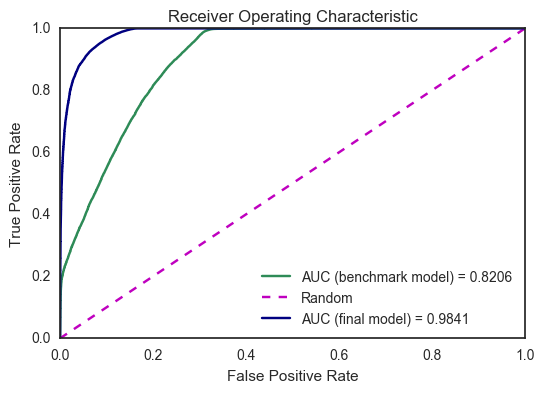

In [59]:
# Display all ROC curves in one chart for comparison

sns.set_style("white")

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'seagreen', label='AUC (benchmark model) = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'m--', label='Random')
plt.legend(loc = 'lower right')
plt.plot(fpr2, tpr2, 'navy', label='AUC (final model) = 0.9841')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [145]:
# Examine predicted probabilities

df_combi = pd.merge(X_test, probs, right_index=True, left_index=True)
df_combi.drop(['Probabilities', 'Unnamed: 0'], axis=1)
df_combi.head(1)
#df_combi = pd.merge(df_combi, y_tests, right_index=True, left_index=True)

,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d,loan_amnt,term,int_rate,installment,grade,...,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,Probabilities,Unnamed: 0,probabilities
0,719163,719163,719163,719163,719163,5000.0,0,10.65,162.87,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.99988


In [150]:
dfy_test = pd.DataFrame(y_test)
df_combinew = pd.merge(df_combi, dfy_test, right_index=True, left_index=True)
df_combinew.head(2)

,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d,loan_amnt,term,int_rate,installment,grade,...,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,Probabilities,Unnamed: 0,probabilities,good_bad_loans
117512,719163,719163,719163,719163,719163,35000.0,1,24.89,1025.05,5,...,0.0,0.0,22200.0,0.0,0.0,0.0,117512.0,117512,0.000025,1
117746,719163,719163,719163,719163,719163,14000.0,0,15.22,486.83,2,...,0.0,0.0,30200.0,0.0,0.0,0.0,117746.0,117746,0.000101,1


In [167]:
# Definition of ambiguous probabilities

ninetyfive = df_combi['probabilities']<0.6
fifty = df_combi['probabilities']>0.4

unclear = df_combi[ninetyfive & fifty]
unclear.probabilities.count()

105

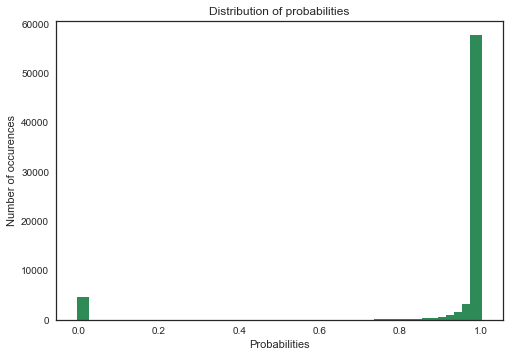

In [171]:
#distribution of predicted probabilities 

hist, bins = np.histogram(df_combi['probabilities'], bins=50)
width = 1.5 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, color='seagreen')
plt.title('Distribution of probabilities')
plt.xlabel('Probabilities')
plt.ylabel('Number of occurences')
plt.show()